<a href="https://colab.research.google.com/github/Axeeh/NBA_Project/blob/main/Progetto_crudo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install nba_api

In [ ]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import requests
#from nba_api.stats import endpoints
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
%matplotlib inline
import requests
import seaborn as sns
"""from nba_api.stats.endpoints import playerdashptshotdefend
from nba_api.stats.endpoints import LeagueDashPtDefend

from nba_api.stats.endpoints import playerdashptshots"""

'from nba_api.stats.endpoints import playerdashptshotdefend\nfrom nba_api.stats.endpoints import LeagueDashPtDefend\n\nfrom nba_api.stats.endpoints import playerdashptshots'

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
path = "/content/gdrive/MyDrive/Project 2024/NBA_2004_2023_Shots.csv"

In [ ]:
data_shots = pd.read_csv(path)

In [ ]:
data_shots

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
0,2023,2022-23,1610612764,Washington Wizards,203078,Bradley Beal,G,SG,10-19-2022,22200004,...,Left Corner 3,Left Side,L,24+ ft.,23.4,12.95,24,1,11,20
1,2023,2022-23,1610612764,Washington Wizards,204001,Kristaps Porzingis,C,C,10-19-2022,22200004,...,Above the Break 3,Center,C,24+ ft.,-0.4,31.45,26,1,10,52
2,2023,2022-23,1610612764,Washington Wizards,1628420,Monte Morris,G,PG,10-19-2022,22200004,...,Restricted Area,Center,C,Less Than 8 ft.,-1.3,5.25,1,1,10,39
3,2023,2022-23,1610612764,Washington Wizards,204001,Kristaps Porzingis,C,C,10-19-2022,22200004,...,Restricted Area,Center,C,Less Than 8 ft.,-0.1,7.25,2,1,10,31
4,2023,2022-23,1610612764,Washington Wizards,1630166,Deni Avdija,F,SF,10-19-2022,22200004,...,Restricted Area,Center,C,Less Than 8 ft.,1.8,7.15,2,1,10,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4012556,2004,2003-04,1610612755,Philadelphia 76ers,2422,John Salmons,G,SG,10-28-2003,20300001,...,Left Corner 3,Left Side,L,24+ ft.,23.3,9.55,23,1,11,21
4012557,2004,2003-04,1610612759,San Antonio Spurs,1938,Manu Ginobili,G,SG,10-28-2003,20300002,...,Above the Break 3,Left Side Center,LC,24+ ft.,15.1,25.85,25,1,11,24
4012558,2004,2003-04,1610612747,Los Angeles Lakers,406,Shaquille O'Neal,C,C,10-28-2003,20300003,...,In The Paint (Non-RA),Center,C,Less Than 8 ft.,-4.7,9.85,6,1,11,39
4012559,2004,2003-04,1610612756,Phoenix Suns,2063,Jake Voskuhl,C,C,10-28-2003,20300002,...,Restricted Area,Center,C,Less Than 8 ft.,-2.3,6.05,2,1,11,42


**PLOTTING**

\

In [ ]:
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    if ax is None:
        ax = plt.gca()

    # Create the basketball hoop
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                                color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    for element in court_elements:
        ax.add_patch(element)

    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-250, 250)
    ax.set_ylim(-47.5, 422.5)

    return ax

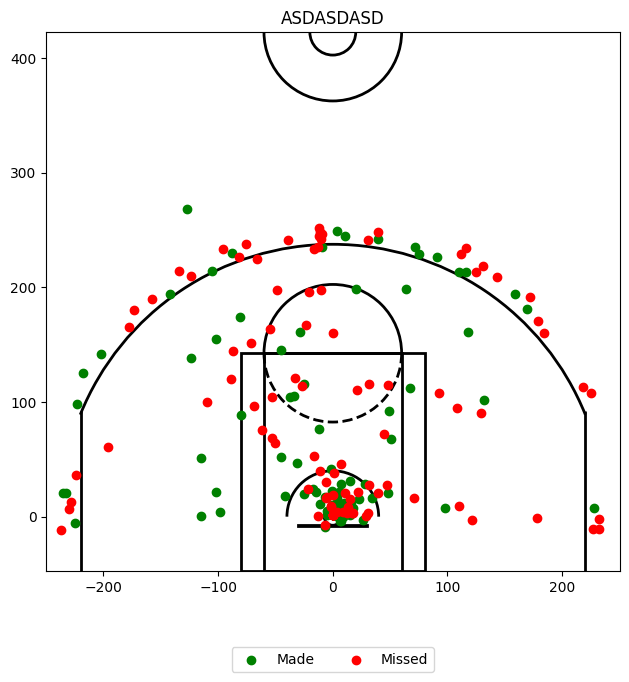

In [ ]:
shots = pd.DataFrame()

shots = data_shots[(data_shots['GAME_ID']) == (22200006)]

fig, ax = plt.subplots(figsize=(10, 7))

draw_court(ax)

made_shots = shots[shots['SHOT_MADE'] == True]
missed_shots = shots[shots['SHOT_MADE'] == False]
ax.scatter(made_shots['LOC_X']*10, made_shots['LOC_Y']*9.4-47.5, color='green', label='Made', zorder=2)
ax.scatter(missed_shots['LOC_X']*10, missed_shots['LOC_Y']*9.4-47.5, color='red', label='Missed', zorder=2)

ax.set_title("ASDASDASD")
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)

plt.savefig("Player_Shot_Chart.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
"""
from nba_api.stats.endpoints import playerdashptshots
from nba_api.stats.static import players, teams
from itertools import product

# Get all players and teams
all_players = players.get_players()
all_teams = teams.get_teams()

# Define the seasons
seasons = ['2019']  # Add more seasons as needed

# Create a cache
cache = {}

# Generate all combinations of player, team, and season
combinations = product(all_players, all_teams, seasons)

# Fetch data for all combinations
for player, team, season in combinations:
    player_id = player['id']
    team_id = team['id']
    # Check if the data is already in the cache
    cache_key = (player_id, team_id, season)
    if cache_key not in cache:
        # Define the parameters for the request
        params = {
            'player_id': player_id,
            'team_id': team_id,
            'season': season,
        }
        # Make the request
        data = playerdashptshots.PlayerDashPtShots(**params)
        # Store the data in the cache
        cache[cache_key] = data

# Process the cached data
for key, data in cache.items():
    player_id, team_id, season = key
    closest_defender_shooting = data.closest_defender_shooting.get_data_frame()
    closest_defender10ft_plus_shooting = data.closest_defender10ft_plus_shooting.get_data_frame()
    # Process the data as needed
    # For example:
    # Do something with closest_defender_shooting and closest_defender10ft_plus_shooting dataframes
"""

"\nfrom nba_api.stats.endpoints import playerdashptshots\nfrom nba_api.stats.static import players, teams\nfrom itertools import product\n\n# Get all players and teams\nall_players = players.get_players()\nall_teams = teams.get_teams()\n\n# Define the seasons\nseasons = ['2019']  # Add more seasons as needed\n\n# Create a cache\ncache = {}\n\n# Generate all combinations of player, team, and season\ncombinations = product(all_players, all_teams, seasons)\n\n# Fetch data for all combinations\nfor player, team, season in combinations:\n    player_id = player['id']\n    team_id = team['id']\n    # Check if the data is already in the cache\n    cache_key = (player_id, team_id, season)\n    if cache_key not in cache:\n        # Define the parameters for the request\n        params = {\n            'player_id': player_id,\n            'team_id': team_id,\n            'season': season,\n        }\n        # Make the request\n        data = playerdashptshots.PlayerDashPtShots(**params)\n       

__________________________________________________________________________________________



**% success rate of shots from every BASIC_ZONE**

In [ ]:
"""
def map_shot_value(shot_dist, shot_type):
    if shot_type == '2PT Field Goal':
      if 0 <= shot_dist <= 20:
        return 2.0 - (shot_dist * 0.1)
      else:
        return 0.0


def map_shot_value(shot_dist, shot_type, shot_zone):
    if shot_type == '2PT Field Goal':
        if shot_zone == 'Restricted Area':
            return 2.0 * 0.6663  # Adjust based on the shooting efficiency for Restricted Area
        elif shot_zone == 'In The Paint (Non-RA)':
            return 2.0 * 0.4436  # Adjust based on the shooting efficiency for In The Paint (Non-RA)
        elif shot_zone == 'Mid-Range':
            return 2.0 * 0.4205  # Adjust based on the shooting efficiency for Mid-Range
        else:
            return 0.0  # Assume other 2PT shots have zero expected points


def map_shot_value(shot_dist, shot_type, shot_zone):
  if shot_type == '2PT Field Goal':
    if shot_zone == 'Restricted Area':
      zone_efficiency = 0.6663
    elif shot_zone == 'In The Paint (Non-RA)':
      zone_efficiency = 0.4436
    elif shot_zone == 'Mid-Range':
      zone_efficiency = 0.4205
    else:
      zone_efficiency = 0.0

    if 0 <= shot_dist <= 20:
      return 2.0 * zone_efficiency - (shot_dist * 0.1 * (1 - zone_efficiency))
    else:
      return 0.0
"""
def map_shot_value(shot_dist, shot_type, shot_zone):
    # Define the zone efficiencies based on shot zone
    zone_efficiencies = {
        'Restricted Area': 0.6663,
        'In The Paint (Non-RA)': 0.4436,
        'Mid-Range': 0.4205,
        'Left Corner 3': 0.3851,
        'Right Corner 3': 0.3855,
        'Above the Break 3': 0.3545,
        'Backcourt': 0.0246
    }

    # Get the zone efficiency based on shot zone
    zone_efficiency = zone_efficiencies.get(shot_zone, 0.0)

    # Calculate shot value
    if shot_type == '2PT Field Goal':
        if 0 <= shot_dist <= 90:
            # Adjust the formula for decreasing probability with distance
            return 2.0 * zone_efficiency - (shot_dist * 0.01 * (1 - zone_efficiency))
        else:
            return 0.0
    elif shot_type == '3PT Field Goal':
        if 0 <= shot_dist <= 30:
            # Adjust the formula for increasing probability with distance
            return 1.0 + (shot_dist * 0.03 * zone_efficiency)
        elif 30 < shot_dist <= 90:
            # Adjust the formula for decreasing probability with distance
            return 3.0 - (shot_dist * 0.01 * (1 - zone_efficiency))
        else:
            return 0.0
    else:
        return 0.0


In [ ]:
season_1 = data_shots[data_shots["SEASON_1"] == 2023]

In [ ]:
shots_per_zone = data_shots[data_shots["SEASON_1"] == 2023].groupby("BASIC_ZONE")["SHOT_MADE"].mean()

shots_per_zone_percentage = shots_per_zone * 100

round(shots_per_zone_percentage, 2)

BASIC_ZONE
Above the Break 3        35.45
Backcourt                 2.46
In The Paint (Non-RA)    44.36
Left Corner 3            38.51
Mid-Range                42.05
Restricted Area          66.63
Right Corner 3           38.55
Name: SHOT_MADE, dtype: float64

In [ ]:
season_1['EXPECTED_POINTS'] = season_1.apply(lambda row: map_shot_value(row['SHOT_DISTANCE'], row['SHOT_TYPE'], row["BASIC_ZONE"]), axis=1)

<ipython-input-16-a58b579c19b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_1['EXPECTED_POINTS'] = season_1.apply(lambda row: map_shot_value(row['SHOT_DISTANCE'], row['SHOT_TYPE'], row["BASIC_ZONE"]), axis=1)


In [ ]:
season_1

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,EXPECTED_POINTS
0,2023,2022-23,1610612764,Washington Wizards,203078,Bradley Beal,G,SG,10-19-2022,22200004,...,Left Side,L,24+ ft.,23.4,12.95,24,1,11,20,1.277272
1,2023,2022-23,1610612764,Washington Wizards,204001,Kristaps Porzingis,C,C,10-19-2022,22200004,...,Center,C,24+ ft.,-0.4,31.45,26,1,10,52,1.276510
2,2023,2022-23,1610612764,Washington Wizards,1628420,Monte Morris,G,PG,10-19-2022,22200004,...,Center,C,Less Than 8 ft.,-1.3,5.25,1,1,10,39,1.329263
3,2023,2022-23,1610612764,Washington Wizards,204001,Kristaps Porzingis,C,C,10-19-2022,22200004,...,Center,C,Less Than 8 ft.,-0.1,7.25,2,1,10,31,1.325926
4,2023,2022-23,1610612764,Washington Wizards,1630166,Deni Avdija,F,SF,10-19-2022,22200004,...,Center,C,Less Than 8 ft.,1.8,7.15,2,1,10,5,1.325926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217215,2023,2022-23,1610612737,Atlanta Hawks,1631495,Donovan Williams,G,SG,04-09-2023,22201216,...,Center,C,Less Than 8 ft.,-2.1,7.45,3,4,1,37,1.322589
217216,2023,2022-23,1610612737,Atlanta Hawks,1631495,Donovan Williams,G,SG,04-09-2023,22201216,...,Right Side Center,RC,24+ ft.,-14.5,26.45,25,4,1,12,1.265875
217217,2023,2022-23,1610612737,Atlanta Hawks,1628981,Bruno Fernando,C,C,04-09-2023,22201216,...,Center,C,Less Than 8 ft.,2.0,7.55,3,4,1,2,1.322589
217218,2023,2022-23,1610612737,Atlanta Hawks,1628981,Bruno Fernando,C,C,04-09-2023,22201216,...,Center,C,24+ ft.,0.2,30.85,25,4,0,28,1.265875


**HYPOTESIS TESTING**

la funzione map_shot_value conferisce una predeterminata probabilità di punti creata a tiro. Adesso quello che dobbiamo fare è paragonare i punti dalla nostra metrica con rispetto del totale dei punti effetivamente generati.

In [ ]:
print(season_1.groupby("BASIC_ZONE")["EXPECTED_POINTS"].sum())

sum_above_the_break = 0
sum_backcourt = 0
sum_In_The_Paint = 0
sum_left_corner = 0
sum_mid_range = 0
sum_Restricted_area = 0
sum_right_corner = 0

for index, row in data_shots.iterrows():
  if row["SHOT_MADE"] == True and row["SHOT_TYPE"] == '2PT Field Goal':
    if row["BASIC_ZONE"] == "In The Paint (Non-RA)":
      sum_In_The_Paint += 2
    elif row["BASIC_ZONE"] == "Mid-Range":
      sum_mid_range += 2
    elif row["BASIC_ZONE"] == "Restricted Area":
      sum_Restricted_area += 2
  elif row["SHOT_MADE"] == True and row["SHOT_TYPE"] == '3PT Field Goal':
    if row["BASIC_ZONE"] == "Above the Break 3":
      sum_above_the_break += 3
    elif row["BASIC_ZONE"] == "Backcourt":
      sum_backcourt += 3
    elif row["BASIC_ZONE"] == "Left Corner 3":
      sum_left_corner += 3
    elif row["BASIC_ZONE"] == "Right Corner 3":
      sum_right_corner += 3

print()
print(f"Above the Break 3 \t {sum_above_the_break}")
print(f"Backcourt \t\t {sum_backcourt}")
print(f"In The Paint (Non-RA) \t {sum_In_The_Paint}")
print(f"Left Corner 3  \t\t {sum_left_corner}")
print(f"Mid-Range \t \t {sum_mid_range}")
print(f"Restricted Area \t {sum_Restricted_area}")
print(f"Right Corner 3  \t {sum_right_corner}")


print()
round(shots_per_zone_percentage, 2)

BASIC_ZONE
Above the Break 3        81157.668740
Backcourt                 1003.499786
In The Paint (Non-RA)    35908.389756
Left Corner 3            13980.878334
Mid-Range                19412.869955
Restricted Area          86297.697648
Right Corner 3           12570.627315
Name: EXPECTED_POINTS, dtype: float64

Above the Break 3 	 869523
Backcourt 		 624
In The Paint (Non-RA) 	 488726
Left Corner 3  		 171684
Mid-Range 	 	 806104
Restricted Area 	 1569680
Right Corner 3  	 158211



BASIC_ZONE
Above the Break 3        35.45
Backcourt                 2.46
In The Paint (Non-RA)    44.36
Left Corner 3            38.51
Mid-Range                42.05
Restricted Area          66.63
Right Corner 3           38.55
Name: SHOT_MADE, dtype: float64

In [ ]:
somma = 0
for index, row in season_1.iterrows():
  if row["SHOT_MADE"] == True and row["SHOT_TYPE"] == '2PT Field Goal':
    somma += 2

somma

145802

In [ ]:
season_1.groupby("SHOT_MADE")["EXPECTED_POINTS"].sum()

SHOT_MADE
False    129871.818184
True     120459.813350
Name: EXPECTED_POINTS, dtype: float64

In [ ]:
shot2pt = data_shots[data_shots["SHOT_TYPE"] == '2PT Field Goal']


max(shot2pt["SHOT_DISTANCE"])

88

**LINEAR REGRESSION**

In [31]:
def calculate_points(row):
    if row['SHOT_MADE']:
        if row['SHOT_TYPE'] == '2PT Field Goal':
            return 2
        elif row['SHOT_TYPE'] == '3PT Field Goal':
            return 3
    return 0

data_shots['POINTS'] = data_shots.apply(calculate_points, axis=1)

In [32]:
from sklearn.linear_model import LinearRegression

# Separate data for 2PT and 3PT shots
data_2pt = data_shots[data_shots['SHOT_TYPE'] == '2PT Field Goal']
data_3pt = data_shots[data_shots['SHOT_TYPE'] == '3PT Field Goal']

In [33]:
# Fit linear regression models for 2PT and 3PT shots
model_2pt = LinearRegression()
model_2pt.fit(data_2pt[['SHOT_DISTANCE']], data_2pt['POINTS'])

model_3pt = LinearRegression()
model_3pt.fit(data_3pt[['SHOT_DISTANCE']], data_3pt['POINTS'])

# Predict expected points for 2PT and 3PT shots
data_2pt['Expected_Points'] = model_2pt.predict(data_2pt[['SHOT_DISTANCE']]).clip(0, 2)
data_3pt['Expected_Points'] = model_3pt.predict(data_3pt[['SHOT_DISTANCE']]).clip(0, 3)

# Combine the results back into the original dataframe
data_shots_updated = pd.concat([data_2pt, data_3pt])

# Ensure Expected_Points is between 0 and 3
data_shots_updated['Expected_Points'] = data_shots_updated['Expected_Points'].clip(0, 3)

<ipython-input-33-c997c217c120>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2pt['Expected_Points'] = model_2pt.predict(data_2pt[['SHOT_DISTANCE']]).clip(0, 2)
<ipython-input-33-c997c217c120>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_3pt['Expected_Points'] = model_3pt.predict(data_3pt[['SHOT_DISTANCE']]).clip(0, 3)


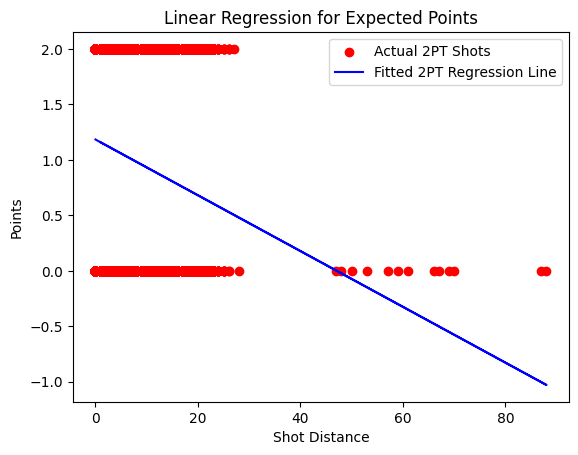

In [34]:
import matplotlib.pyplot as plt


plt.scatter(data_2pt['SHOT_DISTANCE'], data_2pt['POINTS'], color='red', label='Actual 2PT Shots')

# Plot fitted regression line for 2PT shots
plt.plot(data_2pt['SHOT_DISTANCE'], model_2pt.predict(data_2pt[['SHOT_DISTANCE']]), color='blue', label='Fitted 2PT Regression Line')



# Add labels and title
plt.xlabel('Shot Distance')
plt.ylabel('Points')
plt.title('Linear Regression for Expected Points')
plt.legend()

# Show plot
plt.show()

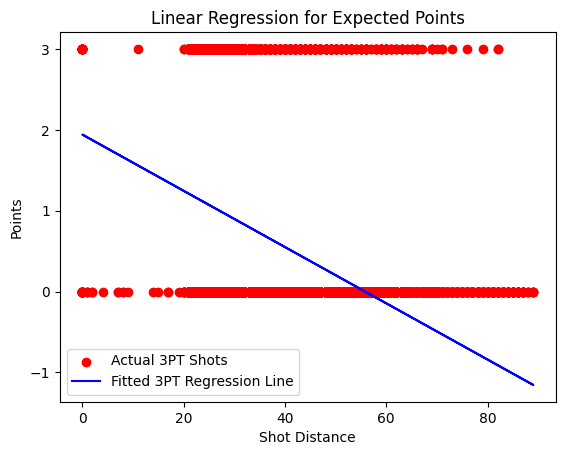

In [36]:
plt.scatter(data_3pt['SHOT_DISTANCE'], data_3pt['POINTS'], color='red', label='Actual 3PT Shots')
plt.plot(data_3pt['SHOT_DISTANCE'], model_3pt.predict(data_3pt[['SHOT_DISTANCE']]), color='blue', label='Fitted 3PT Regression Line')

# Add labels and title
plt.xlabel('Shot Distance')
plt.ylabel('Points')
plt.title('Linear Regression for Expected Points')
plt.legend()

# Show plot
plt.show()